<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Setting up Polytropic [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Initial Data, in Curvilinear Coordinates

## Authors: Zach Etienne, Phil Chang, and Leo Werneck
### Formatting improvements courtesy Brandon Clark

## This module sets up initial data for a TOV star in *spherical, isotropic coordinates*, using the *Numerical* ADM Spherical to BSSN Curvilinear initial data module (numerical = BSSN $\lambda^i$'s are computed using finite-difference derivatives instead of exact expressions).

**Notebook Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [plots](#convergence) at bottom). Note that convergence at the surface of the star will be lower order due to the sharp drop to zero in $T^{\mu\nu}$.</font>

### NRPy+ Source Code for this module: 

* [TOV/TOV_Solver.py](../edit/TOV/TOV_Solver.py); ([**NRPy+ Tutorial module reviewing mathematical formulation and equations solved**](Tutorial-ADM_Initial_Data-TOV.ipynb)); ([**start-to-finish NRPy+ Tutorial module demonstrating that initial data satisfy Hamiltonian constraint**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb)): Tolman-Oppenheimer-Volkoff (TOV) initial data; defines all ADM variables and nonzero $T^{\mu\nu}$ components in Spherical basis.
* [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
* [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

## Introduction:
Here we use NRPy+ to set up initial data for a [simple polytrope TOV star](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation).

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration [(**NRPy+ tutorial on NRPy+ Method of Lines algorithm**)](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on TOV initial data**](Tutorial-ADM_Initial_Data-TOV.ipynb)
    * [**NRPy+ tutorial on validating TOV initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb).
1. Evaluate the Hamiltonian constraint violation
    * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence of Hamiltonian constraint violation to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
1. [Step 2](#adm_id_tov): Set up ADM initial data for polytropic TOV Star
    1. [Step 2.a](#tov_interp): Interpolating the TOV data file as needed
    1. [Step 2.b](#source): Compute source terms $S_{ij}$, $S_{i}$, $S$, and $\rho$
    1. [Step 2.c](#jacobian): Jacobian transformation on the ADM/BSSN source terms
    1. [Step 2.d](#tensor): Rescale tensorial quantities
1. [Step 3](#adm_id_spacetime): Convert ADM spacetime quantity initial data from Spherical to BSSN Curvilinear coordinates
1. [Step 4](#validate): Validating that the TOV initial data satisfy the Hamiltonian constraint
    1. [Step 4.a](#ham_const_output): Output the Hamiltonian Constraint
    1. [Step 4.b](#apply_bcs): Apply singular, curvilinear coordinate boundary conditions
    1. [Step 4.c](#enforce3metric): Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ 
1. [Step 5](#mainc): `TOV_Playground.c`: The Main C Code
1. [Step 6](#plot): Plotting the single-neutron-star initial data
1. [Step 7](#convergence): Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero
1. [Step 8](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initalizenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$


In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh,outCfunction,outputC  # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import sympy as sp               # SymPy: The Python computer algebra package upon which NRPy+ depends
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("TOVID_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"

# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size     = 7.5 # SET BELOW BASED ON TOV STELLAR RADIUS

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial finite difference derivatives;
#           and the core data type.
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.

# Step 3: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 4: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Step 5: Set the direction=2 (phi) axis to be the symmetry axis; i.e.,
#         axis "2", corresponding to the i2 direction.
#         This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")

# Step 6: The MoLtimestepping interface is only used for memory allocation/deallocation
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_method = "Euler" # DOES NOT MATTER; Again MoL interface is only used for memory alloc/dealloc.
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method, RHS_string      = "", post_RHS_string = "",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

# Step 7: Polytropic EOS setup
# For EOS_type, choose either "SimplePolytrope" or "PiecewisePolytrope"
EOS_type = "SimplePolytrope"
# If "PiecewisePolytrope" is chosen as EOS_type, you
#   must also choose the name of the EOS, which can
#   be any of the following:
# 'PAL6', 'SLy', 'APR1', 'APR2', 'APR3', 'APR4',
# 'FPS', 'WFF1', 'WFF2', 'WFF3', 'BBB2', 'BPAL12',
# 'ENG', 'MPA1', 'MS1', 'MS2', 'MS1b', 'PS', 'GS1',
# 'GS2', 'BGN1H1', 'GNH3', 'H1', 'H2', 'H3', 'H4',
# 'H5', 'H6', 'H7', 'PCL2', 'ALF1', 'ALF2', 'ALF3',
# 'ALF4'
EOS_name = 'SLy' # <-- IGNORED IF EOS_type is not PiecewisePolytrope.

<a id='adm_id_tov'></a>

# Step 2: Set up ADM initial data for polytropic TOV Star \[Back to [top](#toc)\]
$$\label{adm_id_tov}$$

As documented [in the TOV Initial Data NRPy+ Tutorial Module](Tutorial-TOV_Initial_Data.ipynb) ([older version here](Tutorial-GRMHD_UnitConversion.ipynb)), we will now set up TOV initial data, storing the densely-sampled result to file (***Courtesy Phil Chang***).

The TOV solver uses an ODE integration routine provided by scipy, so we first make sure that scipy is installed:

In [2]:
!pip install scipy > /dev/null

Next we call the [`TOV.TOV_Solver()` function](../edit/TOV/TOV_Solver.py) ([NRPy+ Tutorial module](Tutorial-ADM_Initial_Data-TOV.ipynb)) to set up the initial data, using the default parameters for initial data. This function outputs the solution to a file named "outputTOVpolytrope.txt".

In [3]:
##########################
# Polytropic EOS example #
##########################
import TOV.Polytropic_EOSs as ppeos

if EOS_type == "SimplePolytrope":
    # Set neos = 1 (single polytrope)
    neos = 1

    # Set rho_poly_tab (not needed for a single polytrope)
    rho_poly_tab = []

    # Set Gamma_poly_tab
    Gamma_poly_tab = [2.0]

    # Set K_poly_tab0
    K_poly_tab0 = 1. # ZACH NOTES: CHANGED FROM 100.

    # Set the eos quantities
    eos = ppeos.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)
    rho_baryon_central = 0.129285
elif EOS_type == "PiecewisePolytrope":
    eos = ppeos.set_up_EOS_parameters__Read_et_al_input_variables(EOS_name)
    rho_baryon_central=2.0
else:
    print("""Error: unknown EOS_type. Valid types are 'SimplePolytrope' and 'PiecewisePolytrope' """)
    sys.exit(1)

import TOV.TOV_Solver as TOV
M_TOV, R_Schw_TOV, R_iso_TOV = TOV.TOV_Solver(eos,
                                              outfile="outputTOVpolytrope.txt",
                                              rho_baryon_central=rho_baryon_central,
                                              return_M_RSchw_and_Riso = True,
                                              verbose = True)

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size = 2.0 * R_iso_TOV

1256 1256 1256 1256 1256 1256
Just generated a TOV star with
* M        = 1.405030336771405e-01 ,
* R_Schw   = 9.566044579232513e-01 ,
* R_iso    = 8.100085557410308e-01 ,
* M/R_Schw = 1.468768334847266e-01 



<a id='tov_interp'></a>

## Step 2.a: Interpolate the TOV data file as needed to set up ADM spacetime quantities in spherical basis (for input into the `Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear` module) and $T^{\mu\nu}$ in the chosen reference metric basis \[Back to [top](#toc)\]
$$\label{tov_interp}$$

The TOV data file just written stored $\left(r,\rho(r),P(r),M(r),e^{\nu(r)}\right)$, where $\rho(r)$ is the total mass-energy density (cf. $\rho_{\text{baryonic}}$).

**METRIC DATA IN TERMS OF ADM QUANTITIES**

The [TOV line element](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) in *Schwarzschild coordinates* is written (in the $-+++$ form):
$$
ds^2 = - c^2 e^\nu dt^2 + \left(1 - \frac{2GM}{rc^2}\right)^{-1} dr^2 + r^2 d\Omega^2.
$$

In *isotropic coordinates* with $G=c=1$ (i.e., the coordinate system we'd prefer to use), the ($-+++$ form) line element is written:
$$
ds^2 = - e^{\nu} dt^2 + e^{4\phi} \left(d\bar{r}^2 + \bar{r}^2 d\Omega^2\right),
$$
where $\phi$ here is the *conformal factor*.

The ADM 3+1 line element for this diagonal metric in isotropic spherical coordinates is given by:
$$
ds^2 = (-\alpha^2 + \beta_k \beta^k) dt^2 + \gamma_{\bar{r}\bar{r}} d\bar{r}^2 + \gamma_{\theta\theta} d\theta^2+ \gamma_{\phi\phi} d\phi^2,
$$

from which we can immediately read off the ADM quantities:
\begin{align}
\alpha &= e^{\nu(\bar{r})/2} \\
\beta^k &= 0 \\
\gamma_{\bar{r}\bar{r}} &= e^{4\phi}\\
\gamma_{\theta\theta} &= e^{4\phi} \bar{r}^2 \\
\gamma_{\phi\phi} &= e^{4\phi} \bar{r}^2 \sin^2 \theta \\
\end{align}

**STRESS-ENERGY TENSOR $T^{\mu\nu}$**

We will also need the stress-energy tensor $T^{\mu\nu}$. [As discussed here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation), the stress-energy tensor is diagonal:

\begin{align}
T^t_t &= -\rho \\
T^i_j &= P \delta^i_j \\
\text{All other components of }T^\mu_\nu &= 0.
\end{align}

Since $\beta^i=0$ the inverse metric expression simplifies to (Eq. 4.49 in [Gourgoulhon](https://arxiv.org/pdf/gr-qc/0703035.pdf)):
$$
g^{\mu\nu} = \begin{pmatrix} 
-\frac{1}{\alpha^2} & \frac{\beta^i}{\alpha^2} \\
\frac{\beta^i}{\alpha^2} & \gamma^{ij} - \frac{\beta^i\beta^j}{\alpha^2}
\end{pmatrix} =
\begin{pmatrix} 
-\frac{1}{\alpha^2} & 0 \\
0 & \gamma^{ij}
\end{pmatrix},
$$

and since the 3-metric is diagonal we get

\begin{align}
\gamma^{\bar{r}\bar{r}} &= e^{-4\phi}\\
\gamma^{\theta\theta} &= e^{-4\phi}\frac{1}{\bar{r}^2} \\
\gamma^{\phi\phi} &= e^{-4\phi}\frac{1}{\bar{r}^2 \sin^2 \theta}.
\end{align}

Thus raising $T^\mu_\nu$ yields a diagonal $T^{\mu\nu}$

\begin{align}
T^{tt} &= -g^{tt} \rho = \frac{1}{\alpha^2} \rho = e^{-\nu(\bar{r})} \rho \\
T^{\bar{r}\bar{r}} &= g^{\bar{r}\bar{r}} P = \frac{1}{e^{4 \phi}} P \\
T^{\theta\theta} &= g^{\theta\theta} P = \frac{1}{e^{4 \phi}\bar{r}^2} P\\
T^{\phi\phi} &= g^{\phi\phi} P = \frac{1}{e^{4\phi}\bar{r}^2 \sin^2 \theta} P 
\end{align}

In [4]:
thismodule = "TOVID"
rbar,theta,rho,P,expnu,exp4phi = par.Cparameters("REAL",thismodule,
                                                 ["rbar","theta","rho","P","expnu","exp4phi"],1e300)
IDalpha = sp.sqrt(expnu)
gammaSphDD = ixp.zerorank2(DIM=3)
gammaSphDD[0][0] = exp4phi
gammaSphDD[1][1] = exp4phi*rbar**2
gammaSphDD[2][2] = exp4phi*rbar**2*sp.sin(theta)**2

T4SphUU = ixp.zerorank2(DIM=4)
T4SphUU[0][0] = rho/expnu
T4SphUU[1][1] = P/exp4phi
T4SphUU[2][2] = P/(exp4phi*rbar**2)
T4SphUU[3][3] = P/(exp4phi*rbar**2*sp.sin(theta)**2)

In [5]:
expr_list = [IDalpha]
name_list = ["*alpha"]
for i in range(3):
    for j in range(i,3):
        expr_list.append(gammaSphDD[i][j])
        name_list.append("*gammaDD"+str(i)+str(j))

desc = """This function takes as input either (x,y,z) or (r,th,ph) and outputs
all ADM quantities in the Cartesian or Spherical basis, respectively."""
name = "ID_TOV_ADM_quantities"
outCparams = "preindent=1,outCverbose=False,includebraces=False"

outCfunction(
    outfile=os.path.join(Ccodesdir, name + ".h"), desc=desc, name=name,
    params="""  const REAL xyz_or_rthph[3],

                const ID_inputs other_inputs,

                REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                REAL *alpha,
                REAL *betaU0,REAL *betaU1,REAL *betaU2,
                REAL *BU0,REAL *BU1,REAL *BU2""",
    body="""
      // Set trivial metric quantities:
      *KDD00 = *KDD01 = *KDD02 = 0.0;
      /**/     *KDD11 = *KDD12 = 0.0;
      /**/              *KDD22 = 0.0;
      *betaU0 = *betaU1 = *betaU2 = 0.0;
      *BU0 = *BU1 = *BU2 = 0.0;

      // Next set gamma_{ij} in spherical basis
      const REAL rbar  = xyz_or_rthph[0];
      const REAL theta = xyz_or_rthph[1];
      const REAL phi   = xyz_or_rthph[2];

      REAL rho,rho_baryon,P,M,expnu,exp4phi;
      TOV_interpolate_1D(rbar,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.rho_baryon_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,
                         &rho,&rho_baryon,&P,&M,&expnu,&exp4phi);\n"""+
    outputC(expr_list,name_list, "returnstring",outCparams),
    opts="DisableCparameters")

Output C function ID_TOV_ADM_quantities() to file TOVID_Ccodes/ID_TOV_ADM_quantities.h


As all input quantities are functions of $r$, we will simply read the solution from file and interpolate it to the values of $r$ needed by the initial data.

1. First we define functions `ID_TOV_ADM_quantities()` and `ID_TOV_TUPMUNU()` that call the [1D TOV interpolator function](../edit/TOV/tov_interp.h) to evaluate the ADM spacetime quantities and $T^{\mu\nu}$, respectively, at any given point $(r,\theta,\phi)$ in the Spherical basis. All quantities are defined as above.
1. Next we will construct the BSSN/ADM source terms $\{S_{ij},S_{i},S,\rho\}$ in the Spherical basis
1. Then we will perform the Jacobian transformation on $\{S_{ij},S_{i},S,\rho\}$ to the desired `(xx0,xx1,xx2)` basis
1. Next we call the *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function to conver the above ADM quantities to the rescaled BSSN quantities in the desired curvilinear coordinate system: [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

$$
{\rm Jac\_dUSph\_dDrfmUD[mu][nu]} = \frac{\partial x^\mu_{\rm Sph}}{\partial x^\nu_{\rm rfm}},
$$

via exact differentiation (courtesy SymPy), and the inverse Jacobian
$$
{\rm Jac\_dUrfm\_dDSphUD[mu][nu]} = \frac{\partial x^\mu_{\rm rfm}}{\partial x^\nu_{\rm Sph}},
$$

using NRPy+'s `generic_matrix_inverter3x3()` function. In terms of these, the transformation of BSSN tensors from Spherical to `"reference_metric::CoordSystem"` coordinates may be written:

$$
T^{\mu\nu}_{\rm rfm} = 
\frac{\partial x^\mu_{\rm rfm}}{\partial x^\delta_{\rm Sph}}
\frac{\partial x^\nu_{\rm rfm}}{\partial x^\sigma_{\rm Sph}} T^{\delta\sigma}_{\rm Sph}
$$

In [6]:
r_th_ph_or_Cart_xyz_oID_xx = []
CoordType_in = "Spherical"
if CoordType_in == "Spherical":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxSph
elif CoordType_in == "Cartesian":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xx_to_Cart
else:
    print("Error: Can only convert ADM Cartesian or Spherical initial data to BSSN Curvilinear coords.")
    exit(1)

# Next apply Jacobian transformations to convert into the (xx0,xx1,xx2) basis

# rho and S are scalar, so no Jacobian transformations are necessary.

Jac4_dUSphorCart_dDrfmUD = ixp.zerorank2(DIM=4)
Jac4_dUSphorCart_dDrfmUD[0][0] = sp.sympify(1)
for i in range(DIM):
    for j in range(DIM):
        Jac4_dUSphorCart_dDrfmUD[i+1][j+1] = sp.diff(r_th_ph_or_Cart_xyz_oID_xx[i],rfm.xx[j])

Jac4_dUrfm_dDSphorCartUD, dummyDET = ixp.generic_matrix_inverter4x4(Jac4_dUSphorCart_dDrfmUD)

# Perform Jacobian operations on T^{mu nu} and gamma_{ij}
T4UU = ixp.register_gridfunctions_for_single_rank2("AUXEVOL","T4UU","sym01",DIM=4)

IDT4UU = ixp.zerorank2(DIM=4)
for mu in range(4):
    for nu in range(4):
        for delta in range(4):
            for sigma in range(4):
                IDT4UU[mu][nu] += \
                     Jac4_dUrfm_dDSphorCartUD[mu][delta]*Jac4_dUrfm_dDSphorCartUD[nu][sigma]*T4SphUU[delta][sigma]

lhrh_list = []
for mu in range(4):
    for nu in range(mu,4):
        lhrh_list.append(lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU"+str(mu)+str(nu)),rhs=IDT4UU[mu][nu]))

desc = """This function takes as input either (x,y,z) or (r,th,ph) and outputs
all ADM quantities in the Cartesian or Spherical basis, respectively."""
name = "ID_TOV_TUPMUNU_xx0xx1xx2"
outCparams = "preindent=1,outCverbose=False,includebraces=False"
outCfunction(
    outfile=os.path.join(Ccodesdir, name + ".h"), desc=desc, name=name,
    params="""const paramstruct *restrict params,REAL *restrict xx[3],
              const ID_inputs other_inputs,REAL *restrict auxevol_gfs""",
    body=outputC([rfm.xxSph[0],rfm.xxSph[1],rfm.xxSph[2]],
                 ["const REAL rbar","const REAL theta","const REAL ph"],"returnstring",
                 "CSE_enable=False,includebraces=False")+"""
      REAL rho,rho_baryon,P,M,expnu,exp4phi;
      TOV_interpolate_1D(rbar,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.rho_baryon_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,
                         &rho,&rho_baryon,&P,&M,&expnu,&exp4phi);\n"""+
    fin.FD_outputC("returnstring",lhrh_list,params="outCverbose=False,includebraces=False").replace("IDX4","IDX4S"),
    loopopts="AllPoints,Read_xxs")

Output C function ID_TOV_TUPMUNU_xx0xx1xx2() to file TOVID_Ccodes/ID_TOV_TUPMUNU_xx0xx1xx2.h


<a id='adm_id_spacetime'></a>

# Step 3: Convert ADM initial data to BSSN-in-curvilinear coordinates \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

This is an automated process, taken care of by [`BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear`](../edit/BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py), and documented [in this tutorial notebook](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [7]:
import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_TOV_ADM_quantities",
                                                               Ccodesdir=Ccodesdir,loopopts="")

Output C function ID_BSSN_lambdas() to file TOVID_Ccodes/ID_BSSN_lambdas.h
Output C function ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs() to file TOVID_Ccodes/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h
Output C function ID_BSSN__ALL_BUT_LAMBDAs() to file TOVID_Ccodes/ID_BSSN__ALL_BUT_LAMBDAs.h


<a id='validate'></a>

# Step 4: Validating that the TOV initial data satisfy the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{validate}$$

We will validate that the TOV initial data satisfy the Hamiltonian constraint, modulo numerical finite differencing error

<a id='ham_const_output'></a>

## Step 4.a: Output the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{ham_const_output}$$

First output the Hamiltonian constraint [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN_constraints.ipynb)

In [8]:
# Enable rfm_precompute infrastructure, which results in
#   BSSN RHSs that are free of transcendental functions,
#   even in curvilinear coordinates, so long as
#   ConformalFactor is set to "W" (default).
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

import BSSN.Enforce_Detgammabar_Constraint as EGC
enforce_detg_constraint_symb_expressions = EGC.Enforce_Detgammabar_Constraint_symb_expressions()


# Now register the Hamiltonian as a gridfunction.
H = gri.register_gridfunctions("AUX","H")
# Then define the Hamiltonian constraint and output the optimized C code.
import BSSN.BSSN_constraints as bssncon
import BSSN.BSSN_stress_energy_source_terms as Bsest
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)
Bsest.BSSN_source_terms_for_BSSN_constraints(T4UU)
bssncon.H += Bsest.sourceterm_H

# Now that we are finished with all the rfm hatted
#           quantities in generic precomputed functional
#           form, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

desc="Evaluate the Hamiltonian constraint"
name="Hamiltonian_constraint"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  REAL *restrict in_gfs, REAL *restrict auxevol_gfs, REAL *restrict aux_gfs""",
    body     = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs", "H"), rhs=bssncon.H),
                              params="outCverbose=False").replace("IDX4","IDX4S"),
    loopopts = "InteriorPoints,Enable_rfm_precompute")

Output C function Hamiltonian_constraint() to file TOVID_Ccodes/Hamiltonian_constraint.h


<a id='bc_functs'></a>

## Step 4.b: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [9]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"))

Wrote to file "TOVID_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( aDD00:4, aDD01:5, aDD02:6, aDD11:7, aDD12:8, aDD22:9,
    alpha:0, betU0:1, betU1:2, betU2:3, cf:0, hDD00:4, hDD01:5, hDD02:6,
    hDD11:7, hDD12:8, hDD22:9, lambdaU0:1, lambdaU1:2, lambdaU2:3, trK:0,
    vetU0:1, vetU1:2, vetU2:3 )
Auxiliary parity: ( H:0 )
AuxEvol parity: ( T4UU00:0, T4UU01:1, T4UU02:2, T4UU03:3, T4UU11:4,
    T4UU12:5, T4UU13:6, T4UU22:7, T4UU23:8, T4UU33:9 )
Wrote to file "TOVID_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"


<a id='enforce3metric'></a>

## Step 4.c: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint \[Back to [top](#toc)\]
$$\label{enforce3metric}$$

Then enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [10]:
# Set up the C function for the det(gammahat) = det(gammabar)
EGC.output_Enforce_Detgammabar_Constraint_Ccode(Ccodesdir,
                                                exprs=enforce_detg_constraint_symb_expressions)

Output C function enforce_detgammabar_constraint() to file TOVID_Ccodes/enforce_detgammabar_constraint.h


<a id='cparams_rfm_and_domainsize'></a>

## Step 4.d: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [11]:
# Step 3.d.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Step 3.d.ii: Set free_parameters.h
# Output to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Step 3.d.iii: Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)

# Step 3.d.iv: Generate xx_to_Cart.h, which contains xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
rfm.xx_to_Cart_h("xx_to_Cart","./set_Cparameters.h",os.path.join(Ccodesdir,"xx_to_Cart.h"))

# Step 3.d.v: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='mainc'></a>

# Step 5: `TOV_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$


In [12]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER)

with open(os.path.join(Ccodesdir,"TOV_Playground_REAL__NGHOSTS.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set TOV stellar parameters
#define TOV_Mass  """+str(M_TOV)+"""
#define TOV_Riso  """+str(R_iso_TOV)+"\n")

In [13]:
%%writefile $Ccodesdir/TOV_Playground.c

// Step P0: Define REAL and NGHOSTS. This header is generated by NRPy+.
#include "TOV_Playground_REAL__NGHOSTS.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set UUGF and VVGF macros, as well as xx_to_Cart()
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Set xx_to_Cart(const paramstruct *restrict params,
//                     REAL *restrict xx[3],
//                     const int i0,const int i1,const int i2,
//                     REAL xCart[3]),
//           which maps xx->Cartesian via
//    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
#include "xx_to_Cart.h"

// Step P5: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P8: Include function for enforcing detgammabar constraint.
#include "enforce_detgammabar_constraint.h"

// Step P4: Declare initial data input struct:
//          stores data from initial data solver,
//          so they can be put on the numerical grid.
typedef struct __ID_inputs {
    REAL Rbar;
    int Rbar_idx;
    int interp_stencil_size;
    int numlines_in_file;
    REAL *r_Schw_arr,*rho_arr,*rho_baryon_arr,*P_arr,*M_arr,*expnu_arr,*exp4phi_arr,*rbar_arr;
} ID_inputs;

// Part P11: Declare all functions for setting up TOV initial data.
/* Routines to interpolate the TOV solution and convert to ADM & T^{munu}: */
#include "../TOV/tov_interp.h"
#include "ID_TOV_ADM_quantities.h"
#include "ID_TOV_TUPMUNU_xx0xx1xx2.h"

/* Next perform the basis conversion and compute all needed BSSN quantities */
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"

// Step P10: Declare function necessary for setting up the initial data.
// Step P10.a: Define BSSN_ID() for BrillLindquist initial data

// Step P10.b: Set the generic driver function for setting up BSSN initial data
void initial_data(const paramstruct *restrict params,const bc_struct *restrict bcstruct,
                  const rfm_struct *restrict rfmstruct,
                  REAL *restrict xx[3], REAL *restrict auxevol_gfs, REAL *restrict in_gfs) {
#include "set_Cparameters.h"
        // Step 1: Set up TOV initial data
    // Step 1.a: Read TOV initial data from data file
    // Open the data file:
    char filename[100];
    sprintf(filename,"./outputTOVpolytrope.txt");
    FILE *in1Dpolytrope = fopen(filename, "r");
    if (in1Dpolytrope == NULL) {
        fprintf(stderr,"ERROR: could not open file %s\n",filename);
        exit(1);
    }
    // Count the number of lines in the data file:
    int numlines_in_file = count_num_lines_in_file(in1Dpolytrope);
    // Allocate space for all data arrays:
    REAL *r_Schw_arr     = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rho_arr        = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rho_baryon_arr = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *P_arr          = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *M_arr          = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *expnu_arr      = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *exp4phi_arr    = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rbar_arr       = (REAL *)malloc(sizeof(REAL)*numlines_in_file);

    // Read from the data file, filling in arrays
    // read_datafile__set_arrays() may be found in TOV/tov_interp.h
    if(read_datafile__set_arrays(in1Dpolytrope, r_Schw_arr,rho_arr,rho_baryon_arr,P_arr,M_arr,expnu_arr,exp4phi_arr,rbar_arr) == 1) {
        fprintf(stderr,"ERROR WHEN READING FILE %s!\n",filename);
        exit(1);
    }
    fclose(in1Dpolytrope);
    REAL Rbar = -100;
    int Rbar_idx = -100;
    for(int i=1;i<numlines_in_file;i++) {
        if(rho_arr[i-1]>0 && rho_arr[i]==0) { Rbar = rbar_arr[i-1]; Rbar_idx = i-1; }
    }
    if(Rbar<0) {
        fprintf(stderr,"Error: could not find rbar=Rbar from data file.\n");
        exit(1);
    }

    ID_inputs TOV_in;
    TOV_in.Rbar = Rbar;
    TOV_in.Rbar_idx = Rbar_idx;

    const int interp_stencil_size = 12;
    TOV_in.interp_stencil_size = interp_stencil_size;
    TOV_in.numlines_in_file = numlines_in_file;

    TOV_in.r_Schw_arr     = r_Schw_arr;
    TOV_in.rho_arr        = rho_arr;
    TOV_in.rho_baryon_arr = rho_baryon_arr;
    TOV_in.P_arr          = P_arr;
    TOV_in.M_arr          = M_arr;
    TOV_in.expnu_arr      = expnu_arr;
    TOV_in.exp4phi_arr    = exp4phi_arr;
    TOV_in.rbar_arr       = rbar_arr;
    /* END TOV INPUT ROUTINE */


    // Step 1.b: Interpolate data from data file to set BSSN gridfunctions
    ID_BSSN__ALL_BUT_LAMBDAs(params,xx,TOV_in, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammabar_constraint(rfmstruct, params,                   in_gfs);
    ID_BSSN_lambdas(params, xx, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammabar_constraint(rfmstruct, params,                   in_gfs);

    ID_TOV_TUPMUNU_xx0xx1xx2(params,xx,TOV_in,auxevol_gfs);

    free(rbar_arr);
    free(rho_arr);
    free(rho_baryon_arr);
    free(P_arr);
    free(M_arr);
    free(expnu_arr);
}

// Step P11: Declare function for evaluating Hamiltonian constraint (diagnostic)
#include "Hamiltonian_constraint.h"

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }

    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data to an exact solution
    initial_data(&params,&bcstruct, &rfmstruct, xx, auxevol_gfs, y_n_gfs);

    // Step 1b: Apply boundary conditions, as initial data
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS,evol_gf_parity, y_n_gfs);
    enforce_detgammabar_constraint(&rfmstruct, &params, y_n_gfs);

    // Evaluate Hamiltonian constraint violation
    Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs,auxevol_gfs, diagnostic_output_gfs);
    char filename[100];
    sprintf(filename,"out%d.txt",Nxx[0]);
    FILE *out2D = fopen(filename, "w");
    LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        REAL xx0 = xx[0][i0];
        REAL xx1 = xx[1][i1];
        REAL xx2 = xx[2][i2];
        REAL xCart[3];
        xx_to_Cart(&params,xx,i0,i1,i2,xCart);
        int idx = IDX3S(i0,i1,i2);
        fprintf(out2D,"%e %e %e %e\n",xCart[1]/TOV_Mass,xCart[2]/TOV_Mass, y_n_gfs[IDX4ptS(CFGF,idx)],
                log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
    }
    fclose(out2D);

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(auxevol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing TOVID_Ccodes//TOV_Playground.c


In [14]:
import cmdline_helper as cmd
cmd.C_compile(os.path.join(Ccodesdir,"TOV_Playground.c"), "TOV_Playground")
cmd.delete_existing_files("out96.txt")
cmd.Execute("TOV_Playground", "96 96 2", "out96.txt")

Compiling executable...
(EXEC): Executing `gcc -Ofast -fopenmp -march=native -funroll-loops TOVID_Ccodes/TOV_Playground.c -o TOV_Playground -lm`...
(BENCH): Finished executing in 3.4261927604675293 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1 ./TOV_Playground 96 96 2`...
(BENCH): Finished executing in 0.22012090682983398 seconds.


<a id='plot'></a>

# Step 6: Plotting the single-neutron-star initial data \[Back to [top](#toc)\]
$$\label{plot}$$

Here we plot the conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the single neutron star centered at the origin: $x/M=y/M=z/M=0$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

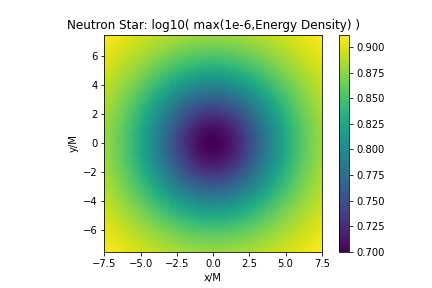

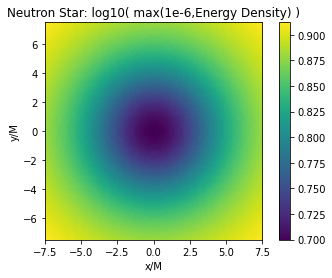

In [15]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

x96,y96,valuesCF96,valuesHam96 = np.loadtxt('out96.txt').T #Transposed for easier unpacking

bounds = 7.5
pl_xmin = -bounds
pl_xmax = +bounds
pl_ymin = -bounds
pl_ymax = +bounds

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((len(x96), 2))
for i in range(len(x96)):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

plt.clf()
plt.title("Neutron Star: log10( max(1e-6,Energy Density) )")
plt.xlabel("x/M")
plt.ylabel("y/M")

# fig, ax = plt.subplots()
# ax.plot(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
# plt.close(fig)
fig96cf = plt.imshow(grid96.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cf)
savefig("BHB.png")
from IPython.display import Image
Image("BHB.png")
# #           interpolation='nearest', cmap=cm.gist_rainbow)

<a id='convergence'></a>

# Step 7: Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero \[Back to [top](#toc)\]
$$\label{convergence}$$

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

First, let's take a look at what the numerical error looks like on the x-y plane at a given numerical resolution, plotting $\log_{10}|H|$, where $H$ is the Hamiltonian constraint violation:

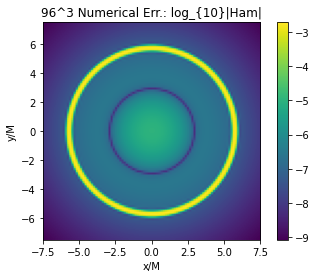

In [16]:
grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next, we set up the same initial data but on a lower-resolution, $48\times 8\times 2$ grid (axisymmetric in the $\phi$ direction). Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96\times 16\times 2$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected, *except* at the star's surface where the stress-energy tensor $T^{\mu\nu}$ sharply drops to zero.

(EXEC): Executing `taskset -c 0,1 ./TOV_Playground 48 48 2`...
(BENCH): Finished executing in 0.22007393836975098 seconds.


<Figure size 432x288 with 0 Axes>

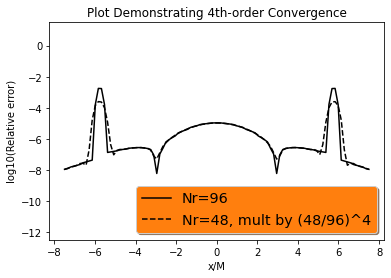

In [17]:
# Now rerun TOV_Playground with twice lower resolution.
cmd.delete_existing_files("out48.txt")
cmd.Execute("TOV_Playground", "48 48 2", "out48.txt")

x48,y48,valuesCF48,valuesHam48 = np.loadtxt('out48.txt').T #Transposed for easier unpacking
points48 = np.zeros((len(x48), 2))
for i in range(len(x48)):
    points48[i][0] = x48[i]
    points48[i][1] = y48[i]

grid48 = griddata(points48, valuesHam48, (grid_x, grid_y), method='cubic')

griddiff_48_minus_96 = np.zeros((100,100))
griddiff_48_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid48_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
outarray = []
for i in range(100):
    for j in range(100):
        griddiff_48_minus_96[i][j] = grid48[i][j] - grid96[i][j]
        griddiff_48_minus_96_1darray[count] = griddiff_48_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid48_1darray_yeq0[i] = grid48[i][j] + np.log10((48./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid48_1darray_yeq0, 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-12.5,1.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 8: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [18]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-
    Setting_up_TOV_initial_data.tex, and compiled LaTeX file to PDF file
    Tutorial-Start_to_Finish-BSSNCurvilinear-
    Setting_up_TOV_initial_data.pdf
